<a href="https://colab.research.google.com/github/vydiep/MLProject/blob/main/PT_RNN_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import relu
import torch.optim as optim
from torchsummary import summary

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
DATA_PATH = "/content/drive/Shareddrives/MLProject/MusicNet/rnn-data.json"
MODEL_PATH = "/content/drive/Shareddrives/MLProject/MusicNet/models/pt-rnn-a.pth"
GRAPH_PATH = "/content/drive/Shareddrives/MLProject/MusicNet/models/pt-rnn-a-graph.png"

## Functions/Classes

In [ ]:
"""
Guidance from Resource: 
    https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/19-%20How%20to%20implement%20an%20RNN-LSTM%20for%20music%20genre%20classification/code/19-%20How%20to%20implement%20an%20RNN-LSTM%20for%20music%20genre%20classification.py
"""

def load_data(data_path):
    """
    Load data from JSON file 

    :param  data_path(string)
        Path to JSON file 

    :return X (ndarray)      
        Features from data
    :return y (ndarray)      
        Label for data
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y


def prepare_datasets(test_size, validation_size):
    """
    Loads data and splits it into train, validation and test sets.

    :param test_size (float)
        Value in [0, 1] for percentage of data set to allocate to test split
    :param validation_size (float)
        Value in [0, 1] for percentage of train set to allocate to validation split

    :return X_train (ndarray)
        Input training set
    :return X_validation (ndarray)
        Input validation set
    :return X_test (ndarray)
        Input test set
    :return y_train (ndarray)
        Target training set
    :return y_validation (ndarray)
        Target validation set
    :return y_test (ndarray)
        Target test set
    """
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
"""
Gudiance from Resources: 
    https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/
    https://middlebury-csci-0451.github.io/CSCI-0451/lecture-notes/text-generation.html 
"""

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, layer_dim=1, output_dim=1):
        """
        Create LSTM Model with 1 hidden layer for binary classification 
        """
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.training_info = {'train_losses': [], 
                              'train_accuracies': [],
                              'val_losses': [], 
                              'val_accuracies': []}

        # 1 LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # # Initialize hidden state with zeros
        # h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # # Initialize cell state
        # c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x)

        # Index hidden state of last time step
        out = out[:,-1,:]
        out = self.fc(relu(out))

        return out

In [ ]:
def train(model, train_loader, val_loader, k_epochs=1):

    begin = time.time()

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Printing purposes
    last_epoch = len(model.training_info['train_losses'])

    for epoch in range(k_epochs):

        # Training
        model.train() #Set model to training mode
        train_loss = 0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            X, y = data
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            output = model(X)

            # Training Loss
            loss = loss_fn(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Training Accuracy 
            predicted = (output.sigmoid() >= 0.5).float()
            predicted = predicted.view(-1)

            total += y.size(0)
            correct += (predicted == y.float()).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100. * (correct / total)

        # Add training loss and accuracy to model's history 
        model.training_info['train_losses'].append(train_loss)
        model.training_info['train_accuracies'].append(train_accuracy)


        # Validation
        model.eval() # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0

        # Do no store computational graph since we are simulating testing 
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                X, y = data
                X = X.to(device)
                y = y.to(device)

                output = model(X)

                # Validation Loss
                loss = loss_fn(output.squeeze(), y)
                val_loss += loss.item()

                # Validation Accuracy 
                predicted = (output.sigmoid() >= 0.5).float()
                predicted = predicted.view(-1)

                total += y.size(0)
                correct += (predicted == y.float()).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100. * (correct / total)

            # Add validation loss and accuracy to model's history 
            model.training_info['val_losses'].append(val_loss)
            model.training_info['val_accuracies'].append(val_accuracy)

        print(f'Epoch {last_epoch+epoch+1}:') 
        print(f'\tTrain Loss={train_loss:.4f} Train Accuracy={train_accuracy:.2f}%')
        print(f'\tVal Loss  ={val_loss:.4f} Val Accuracy  ={val_accuracy:.2f}%')

    end = time.time()
    print(f'Finished training in {round(end - begin)}s')

In [ ]:
def test(model, test_loader):
    correct = 0
    total = 0
    
    # Do no store computational graph since we are testing 
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)

            predicted = (y_hat.sigmoid() >= 0.5).float()
            predicted = predicted.view(-1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')

In [ ]:
def plot_history(model):
    """
    Plot the models history of training/validation accuracies 
    and training/validation losses on separate graphs based on what is stored 
    in its training info
    """
    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(model.training_info["train_accuracies"], label="train accuracy")
    axs[0].plot(model.training_info["val_accuracies"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(model.training_info["train_losses"], label="train error")
    axs[1].plot(model.training_info["val_losses"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    fig.tight_layout()

    plt.savefig(GRAPH_PATH)
    plt.show()
    

## Data Loading/Prep, Training, and Results

In [ ]:
batch_size = 32

# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_validation)
val_targets = torch.Tensor(y_validation)
test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test)

train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)
test_dataset = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
model = LSTMModel(input_dim=13)
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.training_info['train_losses'] = checkpoint['train_losses']
model.training_info['train_accuracies'] = checkpoint['train_accuracies']
model.training_info['val_losses'] = checkpoint['val_losses']
model.training_info['val_accuracies'] = checkpoint['val_accuracies']
model.eval()
model.training_info

{'train_losses': [0.6838308476438426,
  0.6628681216577087,
  0.6429754019987703,
  0.6306735951491077,
  0.6193810069199764,
  0.6042929984102345,
  0.5928355804597488,
  0.5841893565775168,
  0.5781203225405529,
  0.5727109933140302,
  0.5637856131852276,
  0.5560312216932123,
  0.5433252700651535,
  0.5381411882964048,
  0.5287178604289738,
  0.5236311771652915,
  0.5152608177276573,
  0.5107059051292111,
  0.5056168984885168,
  0.5001306326100321,
  0.4925486020969622,
  0.4857289360629188,
  0.4810730288125048,
  0.4726822279920482,
  0.46579792764451766,
  0.46222343679630395,
  0.45292640906391723,
  0.4534196642914204,
  0.45004073959408386,
  0.44174153816820394,
  0.44302797528228377,
  0.4319217253212977,
  0.42559146730586733,
  0.42146190338664585,
  0.42187964193748706,
  0.41591690917207735,
  0.41652579048667293,
  0.41328530359749843,
  0.40262317657470703,
  0.3969426522351275,
  0.388149625273666,
  0.3907133572631412,
  0.3824001187928999,
  0.3823828978670968,
  0.

In [ ]:
train(model, train_loader, val_loader, k_epochs = 25)

Epoch 151:
	Train Loss=0.2277 Train Accuracy=90.59%
	Val Loss  =0.4640 Val Accuracy  =82.68%
Epoch 152:
	Train Loss=0.2161 Train Accuracy=91.89%
	Val Loss  =0.4687 Val Accuracy  =82.42%
Epoch 153:
	Train Loss=0.2195 Train Accuracy=91.00%
	Val Loss  =0.4717 Val Accuracy  =82.42%
Epoch 154:
	Train Loss=0.2086 Train Accuracy=91.48%
	Val Loss  =0.4626 Val Accuracy  =83.98%
Epoch 155:
	Train Loss=0.2007 Train Accuracy=92.11%
	Val Loss  =0.4177 Val Accuracy  =83.07%
Epoch 156:
	Train Loss=0.2003 Train Accuracy=92.61%
	Val Loss  =0.4167 Val Accuracy  =83.59%
Epoch 157:
	Train Loss=0.2017 Train Accuracy=92.11%
	Val Loss  =0.4708 Val Accuracy  =82.55%
Epoch 158:
	Train Loss=0.1994 Train Accuracy=92.30%
	Val Loss  =0.4380 Val Accuracy  =83.46%
Epoch 159:
	Train Loss=0.2190 Train Accuracy=91.35%
	Val Loss  =0.4468 Val Accuracy  =85.42%
Epoch 160:
	Train Loss=0.2084 Train Accuracy=91.82%
	Val Loss  =0.4560 Val Accuracy  =82.16%
Epoch 161:
	Train Loss=0.2343 Train Accuracy=90.81%
	Val Loss  =0.4294

In [ ]:
test(model, test_loader) 

Test accuracy: 84 %


In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'train_losses': model.training_info['train_losses'],
            'train_accuracies': model.training_info['train_accuracies'],
            'val_losses': model.training_info['val_losses'],
            'val_accuracies': model.training_info['val_accuracies']
            }, MODEL_PATH)

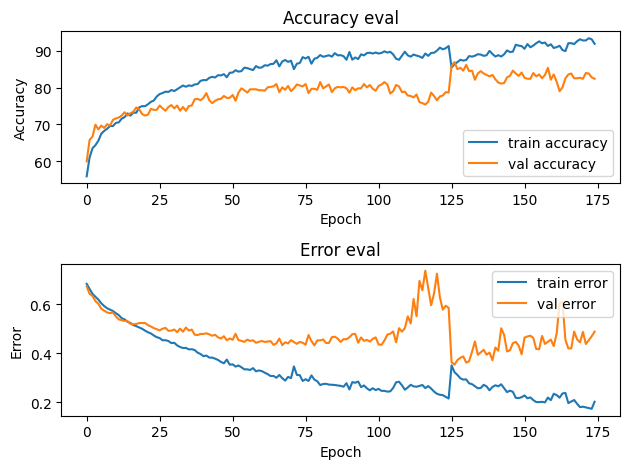

In [ ]:
plot_history(model)